In [1]:
import torch     
import torch.nn as nn    
import torchvision    
from torch.utils.data import Dataset, DataLoader        
from torchvision import transforms, utils     
from PIL import Image  

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
# 定义超参数
# RNN的输入是一个序列，sequence_length为序列长度，input_size为序列每个长度。
sequence_length = 28*3
input_size = 28
# 定义RNN隐含单元的大小。
hidden_size = 128
# 定义rnn的层数
num_layers = 2
# 识别的类别数量
num_classes = 7
# 批的大小
batch_size = 32
# 定义迭代次数
num_epochs = 50
# 定义学习率
learning_rate = 0.001

In [4]:
def default_loader(path):        
    # 注意要保证每个batch的tensor大小时候一样的。        
    return Image.open(path).convert('RGB')   

In [5]:
class MyDataset(Dataset):        
    def __init__(self, txt, transform=None, target_transform=None, loader=default_loader):        
        fh = open(txt, 'r')        
        imgs = []        
        for line in fh:        
            line = line.strip('\n')        
            # line = line.rstrip()        
            words = line.split(' ')        
            imgs.append((words[0],int(words[1])))        
        self.imgs = imgs        
        self.transform = transform        
        self.target_transform = target_transform        
        self.loader = loader        
            
    def __getitem__(self, index):        
        fn, label = self.imgs[index]        
        img = self.loader(fn)        
        if self.transform is not None:        
            img = self.transform(img)        
        return img,label        
            
    def __len__(self):        
        return len(self.imgs)   

In [6]:
def get_loader(dataset='/mnt/emotion_recognition/dataset/basic/Image/rnntrain_label.txt', crop_size=128, image_size=28, batch_size=2, mode='train', num_workers=1):        
    """Build and return a data loader."""        
    transform = []        
    if mode == 'train':        
        transform.append(transforms.RandomHorizontalFlip())        
    transform.append(transforms.CenterCrop(crop_size))        
    transform.append(transforms.Resize(image_size))        
    transform.append(transforms.ToTensor())        
    transform.append(transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)))        
    transform = transforms.Compose(transform)        
    train_data=MyDataset(txt=dataset, transform=transform)        
    data_loader = DataLoader(dataset=train_data,        
                                  batch_size=batch_size,        
                                  shuffle=(mode=='train'),        
                                  num_workers=num_workers)        
    return data_loader   

In [7]:
# 注意要保证每个batch的tensor大小时候一样的。        
# data_loader = DataLoader(train_data, batch_size=2,shuffle=True)        
train_loader = get_loader('/mnt/emotion_recognition/dataset/basic/Image/rnntrain_label.txt', batch_size=batch_size)        
print(len(train_loader))        
test_loader = get_loader('/mnt/emotion_recognition/dataset/basic/Image/rnntest_label.txt', batch_size=batch_size)        
print(len(test_loader))  
print(train_loader)

384
96


In [8]:
# 定义RNN（LSTM）
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        # Set initial hidden and cell states 
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device) 
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        
        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0, c0))  # out: tensor of shape (batch_size, seq_length, hidden_size)
        
        # Decode the hidden state of the last time step
        out = self.fc(out[:, -1, :])
        return out

In [9]:
model = RNN(input_size, hidden_size, num_layers, num_classes).to(device)

In [10]:
print(model)

RNN(
  (lstm): LSTM(28, 128, num_layers=2, batch_first=True)
  (fc): Linear(in_features=128, out_features=7, bias=True)
)


In [11]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [12]:
# 训练模型 
train_acc=[]
total_step = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images.reshape(-1, sequence_length, input_size).to(device)
#         images = images.to(device)
#         CUDA_LAUNCH_BLOCKING=1
        labels = labels.to(device)
        
        # 前向传播+计算loss  
        with torch.cuda.amp.autocast():
            outputs=model(images)
            loss=criterion(outputs,labels)
#         outputs = model(images)
#         loss = criterion(outputs, labels)
        
        # 后向传播+调整参数 
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        _,argmax=torch.max(outputs,1)
        acc=(labels==argmax.squeeze()).float().mean()
        train_acc.append(acc.item())
        # 每100个batch打印一次数据    
        if (i+1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f},Accuracy:{:.3f}' 
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item(),acc.item()))


Epoch [1/50], Step [100/384], Loss: 1.5866,Accuracy:0.438
Epoch [1/50], Step [200/384], Loss: 1.8873,Accuracy:0.375
Epoch [1/50], Step [300/384], Loss: 1.4774,Accuracy:0.500
Epoch [2/50], Step [100/384], Loss: 1.5993,Accuracy:0.344
Epoch [2/50], Step [200/384], Loss: 1.5884,Accuracy:0.281
Epoch [2/50], Step [300/384], Loss: 1.2569,Accuracy:0.562
Epoch [3/50], Step [100/384], Loss: 1.8411,Accuracy:0.312
Epoch [3/50], Step [200/384], Loss: 1.0931,Accuracy:0.656
Epoch [3/50], Step [300/384], Loss: 1.2159,Accuracy:0.562
Epoch [4/50], Step [100/384], Loss: 1.5120,Accuracy:0.438
Epoch [4/50], Step [200/384], Loss: 1.3160,Accuracy:0.594
Epoch [4/50], Step [300/384], Loss: 1.3287,Accuracy:0.531
Epoch [5/50], Step [100/384], Loss: 1.0626,Accuracy:0.625
Epoch [5/50], Step [200/384], Loss: 1.5457,Accuracy:0.531
Epoch [5/50], Step [300/384], Loss: 1.3637,Accuracy:0.438
Epoch [6/50], Step [100/384], Loss: 1.0370,Accuracy:0.625
Epoch [6/50], Step [200/384], Loss: 1.0481,Accuracy:0.656
Epoch [6/50], 

In [13]:
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.reshape(-1, sequence_length, input_size).to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Test Accuracy of the model on the 10000 test images: {} %'.format(100 * correct / total)) 

Test Accuracy of the model on the 10000 test images: 60.22171503097489 %


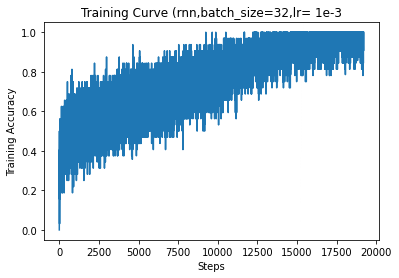

In [14]:
import matplotlib.pyplot as plt
plt.plot(train_acc)
plt.title("Training Curve (rnn,batch_size=32,lr= 1e-3")
plt.xlabel("Steps")
plt.ylabel("Training Accuracy")
plt.show()

In [17]:
nb_classes = 7

confusion_matrix = torch.zeros(nb_classes, nb_classes)
with torch.no_grad():
    for i, (images, labels) in enumerate(test_loader):
        images = images.reshape(-1, sequence_length, input_size).to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        for t, p in zip(labels.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

print(confusion_matrix)
print(confusion_matrix.diag()/confusion_matrix.sum(1))

tensor([[ 148.,   10.,    9.,   47.,   44.,   10.,   61.],
        [   3.,   25.,    4.,   21.,   12.,    5.,    4.],
        [  10.,    6.,   32.,   27.,   24.,   13.,   48.],
        [  16.,    4.,   21., 1002.,   51.,   12.,   79.],
        [  19.,    5.,   26.,  115.,  202.,    8.,  102.],
        [  14.,   10.,    8.,   32.,   24.,   59.,   15.],
        [  29.,    2.,   44.,   73.,  152.,    6.,  374.]])
tensor([0.4498, 0.3378, 0.2000, 0.8456, 0.4235, 0.3642, 0.5500])


Text(0.5, 69.0, 'Predicted label')

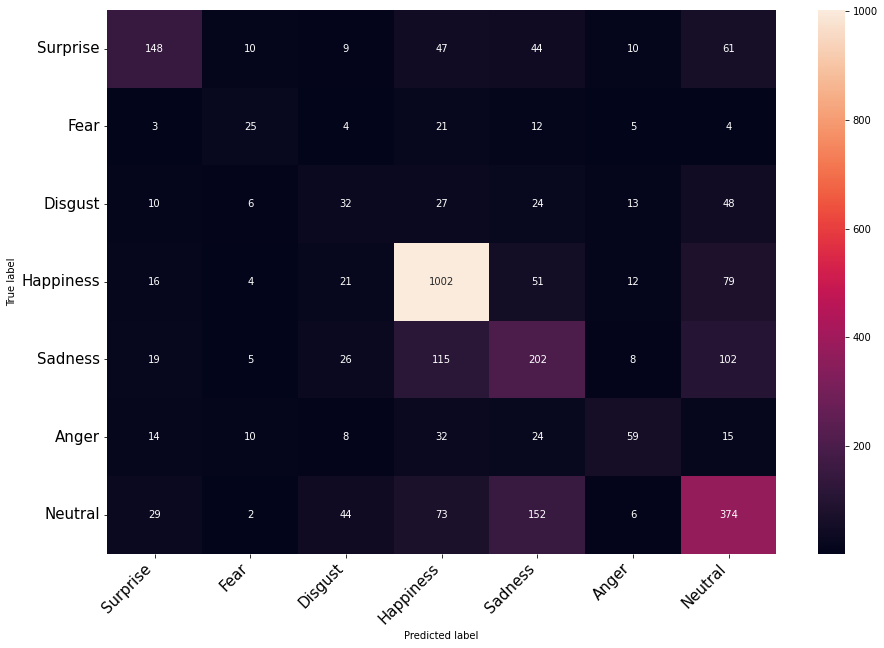

In [20]:
import pandas as pd
import seaborn as sns
plt.figure(figsize=(15,10))


class_names = ['Surprise' , 'Fear' , 'Disgust' , 'Happiness' , 'Sadness' ,'Anger' ,'Neutral']
df_cm = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names).astype(int)
heatmap = sns.heatmap(df_cm, annot=True, fmt="d")

heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right',fontsize=15)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right',fontsize=15)
plt.ylabel('True label')
plt.xlabel('Predicted label')

In [21]:
torch.save('model.state_dict' , 'rnn.pth')